In [1]:
library(tidyverse)
library(repr)
library(dplyr) 
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

(1) Data Description: 
- 

Session: This is likely collected via an automated system that they embedded within the server.

Variable summary:
There are 5 variables in the sessions.csv. 1535 observations.
| Variable name       | Data type | Description                                 |
| :--------           | :-------  | :---------                                  |
| hashedEmail         | Categorial| User identification via email               |
| start_time          | Date-time | Beginning of a session in dd/mm/yyyy, hh:mm |     
| end_time            | Date-time | End of a session in dd/mm/yyyy, hh:mm       | 
| original_start_time | Numerical | Start time recorded in milliseconds         |
| original_end_time   | Numerical | End time recorded in milliseconds           |

Summary statistics:

Session duration:

|Count	|Mean  | Median |Standard Deviation	 |Variance |	Minimum (hours)	| Maximum (hours) |
|:----  |:---  |:----   |:---- |:----    |:---- |:---   |
|1533	|48.49 |0	    | 79.69|6350.52	 |   0	| 333.33|


Sessions per user: 


|Mean	|Minimum  | Maximum |
|:----  |:---  |:----   |
|12.28	|310 |1	    |


Issues: 
1. There is missing data for end times for rows like 681 and 1019.
2. What constitues a session. Large playtime can be someone genuinely playing or forgetting to close the game. Any trackers of activity built-in?
3. Unknown period of gaming for each individual. Meaning, a player can have 50 sessions and they can all come from within the same month, or someone could have 50 sessions but it's spread out within all 4 months. Session frequency does not really say much on its own. Need to perform more analyses to find out each players' sessions and frequency.
4. High variance. Makes this dataset bad for prediction.


Player: This is likely collected via a combination surveys and an automated system that they embedded within the server.

Variable summary: There are 7 variables in the players.csv. 196 observations

| Variable name       | Data type | Description                                 |From where
| :--------           | :-------  | :---------                                  |:----
| experience         | Categorial| Player skill classification: beginner, amateur, regular, veteran, pro|self-reported|
| subscribe          | Boolean | True or false, whether a player has subscribed to something|      from system|
| hashedEmail            | Categorical| User identification via email| from system| 
| played_hours | Numerical | Hours of gameplay for each player       | from system  |
| name   | Categorical | Name/chosen name of player          |self-reported
| gender   | Categorical | Player's identity         | self-reported |
| age   | Numerical | Players age in years          | self-reported |

Summary statistics:


|Stat	|Age  | played_hours |
|:----  |:---  |:----   |
|Mean	|21.14 |5.85	    |
|Median	|19 |0.1	    |
|Standard Deviation	|7.39 |28.36	    |
|Variance	|54.61 |804.14	    |
|Minimum	|9 |0	    |
|Maximum|58 |223.1	    |

Issues: 
1. There is missing data for ages.
2. Weird outliers. The top 6 highest hours ranges from 53 to 223 hours. These outliers heavily affect the skewedness and thus the data's use in prediction. 
3. Quick scroll through and there are a lot of 0 hours in there. Even spotted a supposed Veteran with 0 hours of playtime (103)
4. Much of the data here appears to be self-reported, which will result in bias and misrepresentation as everyone's definition of each of the 5 classifications would inevitably be different, unless a very specific metric was provided for that specific question. As for the players' ages, they could lie about it and nobody would know unless the survey asked for direct identification. So there is high uncertainty for the reliability of the data.


Below are the code cells I used to calculate the summary statistics and such.

In [3]:
sessions <- read_csv("data/sessions.csv")
players <- read_csv("data/players.csv")

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
player_age_stats<-players|>
    filter(!is.na(Age))|>
    summarise(
        count = n(),
        mean = round(mean(Age), 2),
        median = round(median(Age), 2),
        sd = round(sd(Age), 2),
        variance = round(var(Age), 2),
        min = round(min(Age),2),
        max = round(max(Age),2))
player_age_stats

player_time_stats<-players|>
    summarise(
        count = n(),
        mean = round(mean(played_hours), 2),
        median = round(median(played_hours), 2),
        sd = round(sd(played_hours), 2),
        variance = round(var(played_hours), 2),
        min = round(min(played_hours),2),
        max = round(max(played_hours),2))
player_time_stats

count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,19,7.39,54.61,9,58


count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,5.85,0.1,28.36,804.14,0,223.1


In [25]:
sessions <- sessions |>
    mutate(original_end_time = as.numeric(as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")),
           original_start_time = as.numeric(as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")))|>
    filter(!is.na(original_end_time))|>
    mutate(session_duration_mins = (original_end_time - original_start_time)/60)

In [51]:
session_stats<-sessions|>
    summarise(
        count = n(),
        mean = round(mean(session_duration_mins), 2),
        median = round(median(session_duration_mins), 2),
        sd = round(sd(session_duration_mins), 2),
        variance = round(var(session_duration_mins), 2),
        min = round(min(session_duration_mins),2),
        max = round(max(session_duration_mins),2))
session_stats


mean_sessions_per_user <- sessions |>
    count(hashedEmail, name = "session_count")|>
    summarise(mean = mean(session_count),
              max = max(session_count),
              min = min(session_count))
mean_sessions_per_user

count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1533,50.86,30,55.57,3088.42,3,259


mean,max,min
<dbl>,<int>,<int>
12.264,310,1


(2) Questions:
- 

Broad question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific question: Can **experience** and **subscription** predict the **total session hours** in the players dataset? 

Method:
- Merge the two datasets together
- Find their played hours based on the sessions dataset since the data in there is within the observation period.

To find each player's total sessions:
- Group them by their email and sum up their total sessions' minutes

(3) Exploratory Data Analysis and Visualization:
- 

Q: Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.

|Stat	|Age  | played_hours |
|:----  |:---  |:----   |
|Mean	|21.14 |5.85	    |

In [48]:
combined_data <- sessions|>
    group_by(hashedEmail)|>
   summarise(
        total_sessions = n(),
        total_session_mins = sum(session_duration_mins))|>
    left_join(players, by = "hashedEmail")|>
    mutate(total_session_hrs = total_session_mins / 60)
combined_data
#avg_session_hrs is within the observation period. Use that instead. Not sure about the timeframe of played_hours or what it actually reprsents.    

hashedEmail,total_sessions,total_session_mins,experience,subscribe,played_hours,name,gender,Age,total_session_hrs
<chr>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,106,Regular,TRUE,1.5,Isaac,Male,20,1.7666667
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,30,Pro,FALSE,0.4,Lyra,Male,21,0.5000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,11,Beginner,TRUE,0.1,Osiris,Male,17,0.1833333
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,4795,Amateur,TRUE,56.1,Dana,Male,23,79.91667
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,9,Amateur,TRUE,0.1,Fatima,Male,17,0.15000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,72,Beginner,TRUE,1.1,Caden,Male,20,1.20000


In [52]:
nrow(combined_data)

[1] 125

hashedEmail,total_sessions,total_session_mins,experience,subscribe,played_hours,name,gender,Age,total_session_hrs
<chr>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,106,Regular,TRUE,1.5,Isaac,Male,20,1.7666667
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,30,Pro,FALSE,0.4,Lyra,Male,21,0.5000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,11,Beginner,TRUE,0.1,Osiris,Male,17,0.1833333
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1,80,Pro,TRUE,1.2,Sakura,Male,17,1.333333
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,9,Amateur,TRUE,0.1,Fatima,Male,17,0.150000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,72,Beginner,TRUE,1.1,Caden,Male,20,1.200000


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


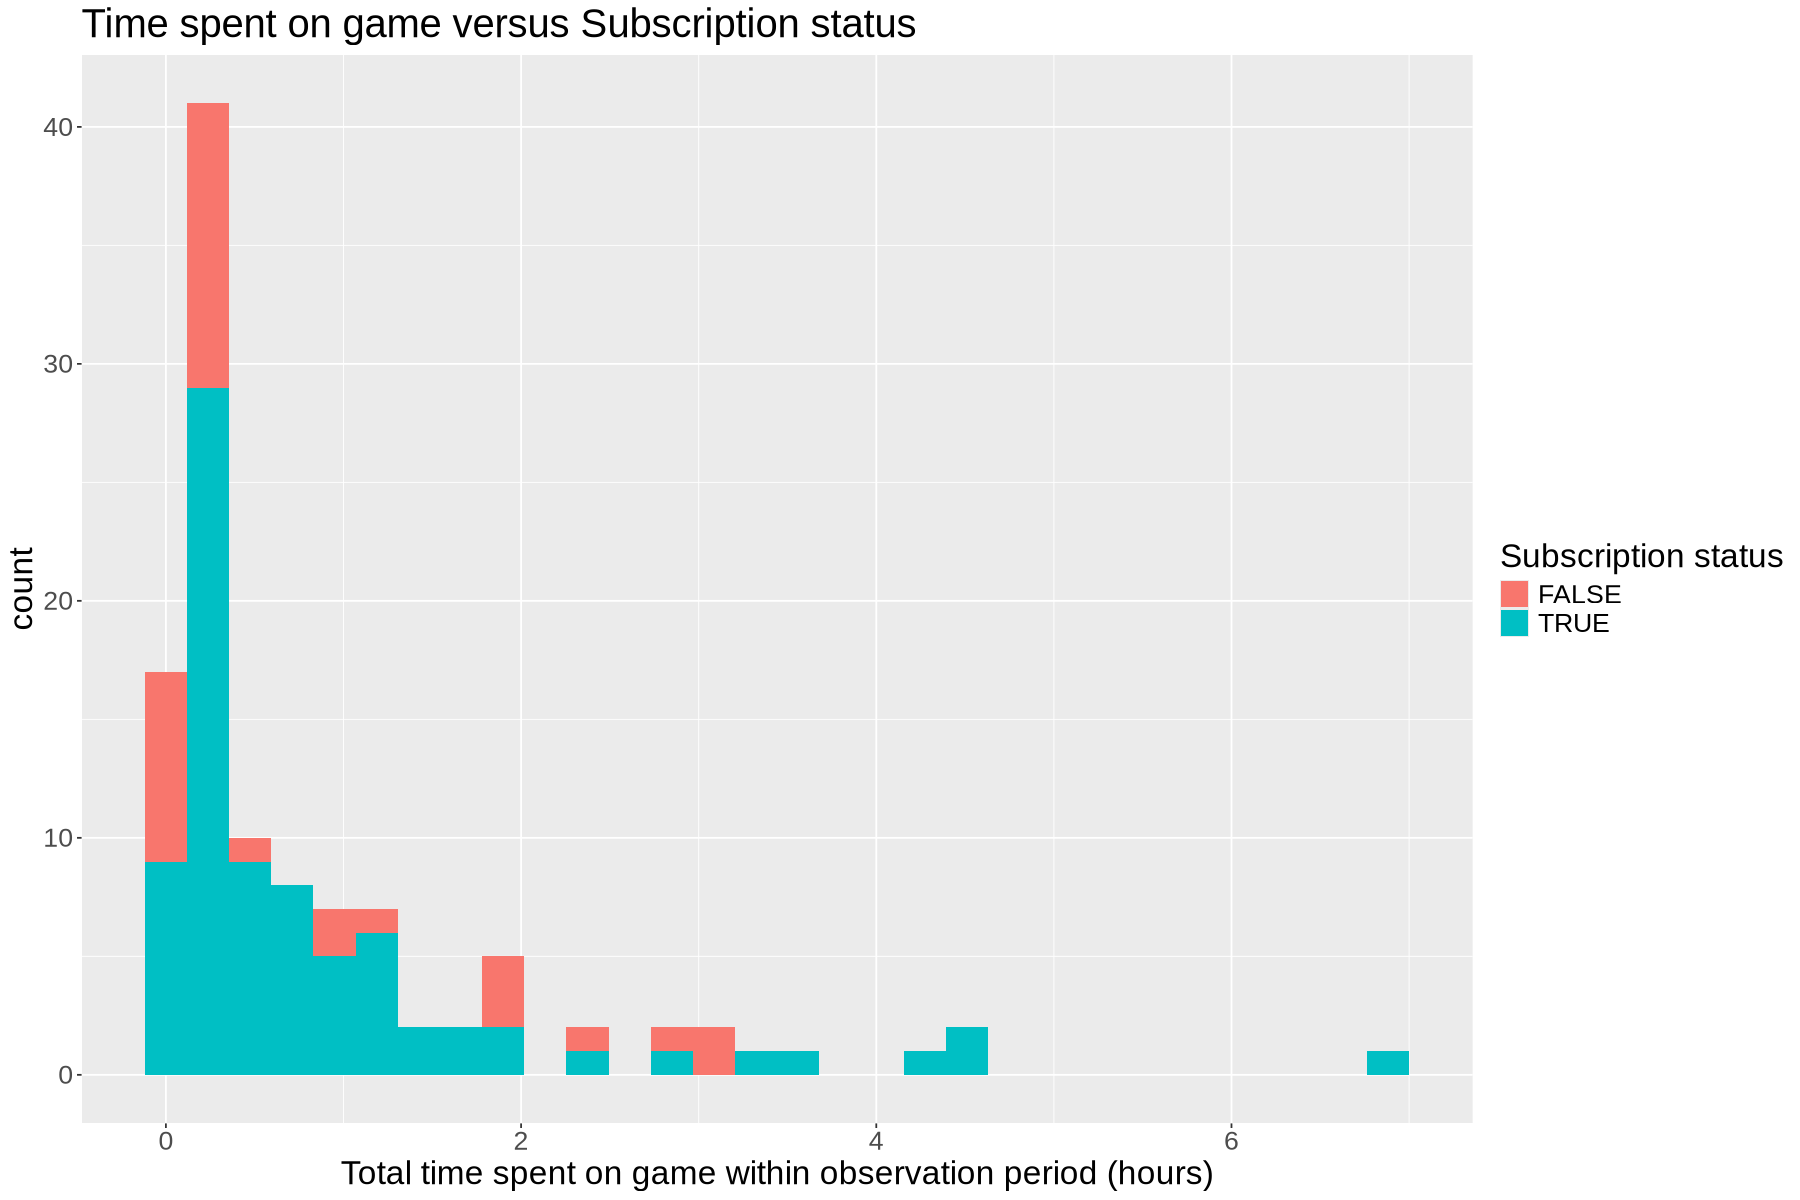

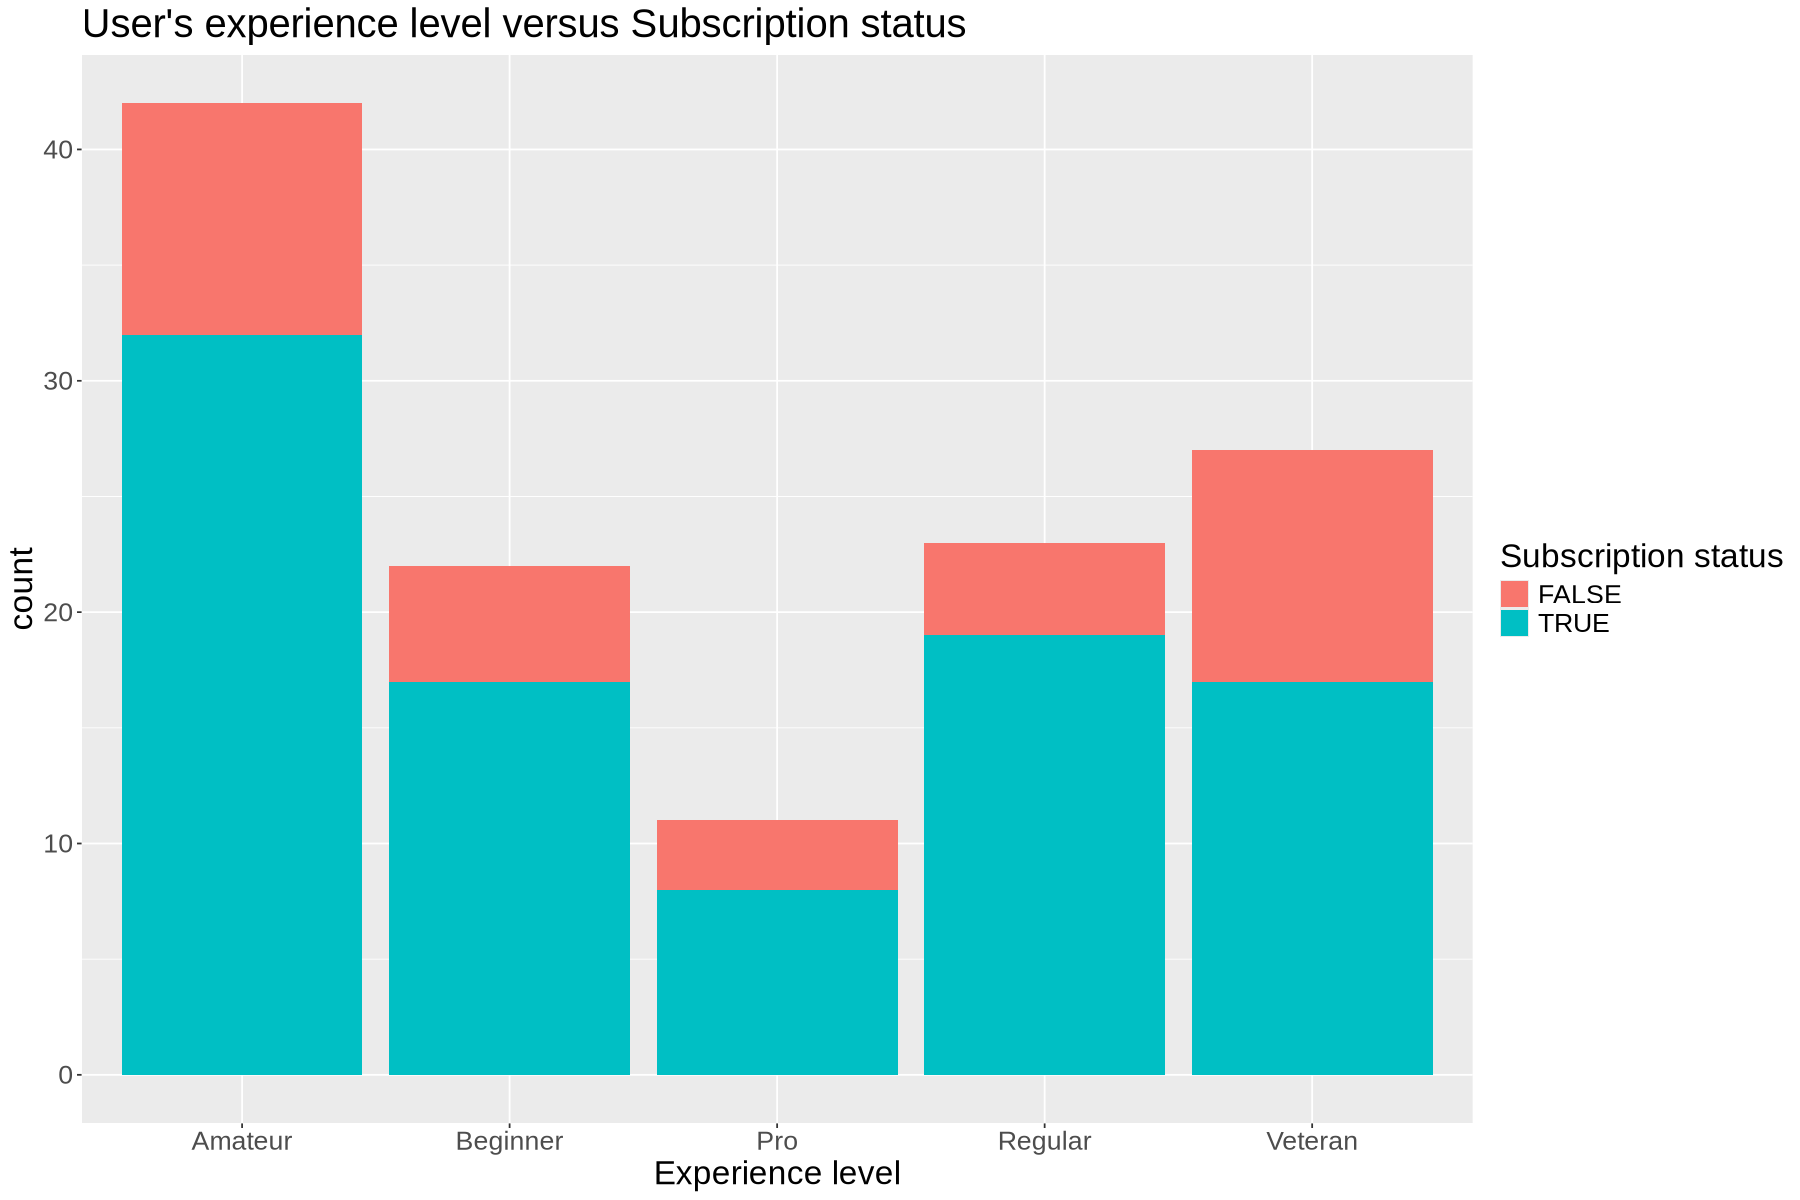

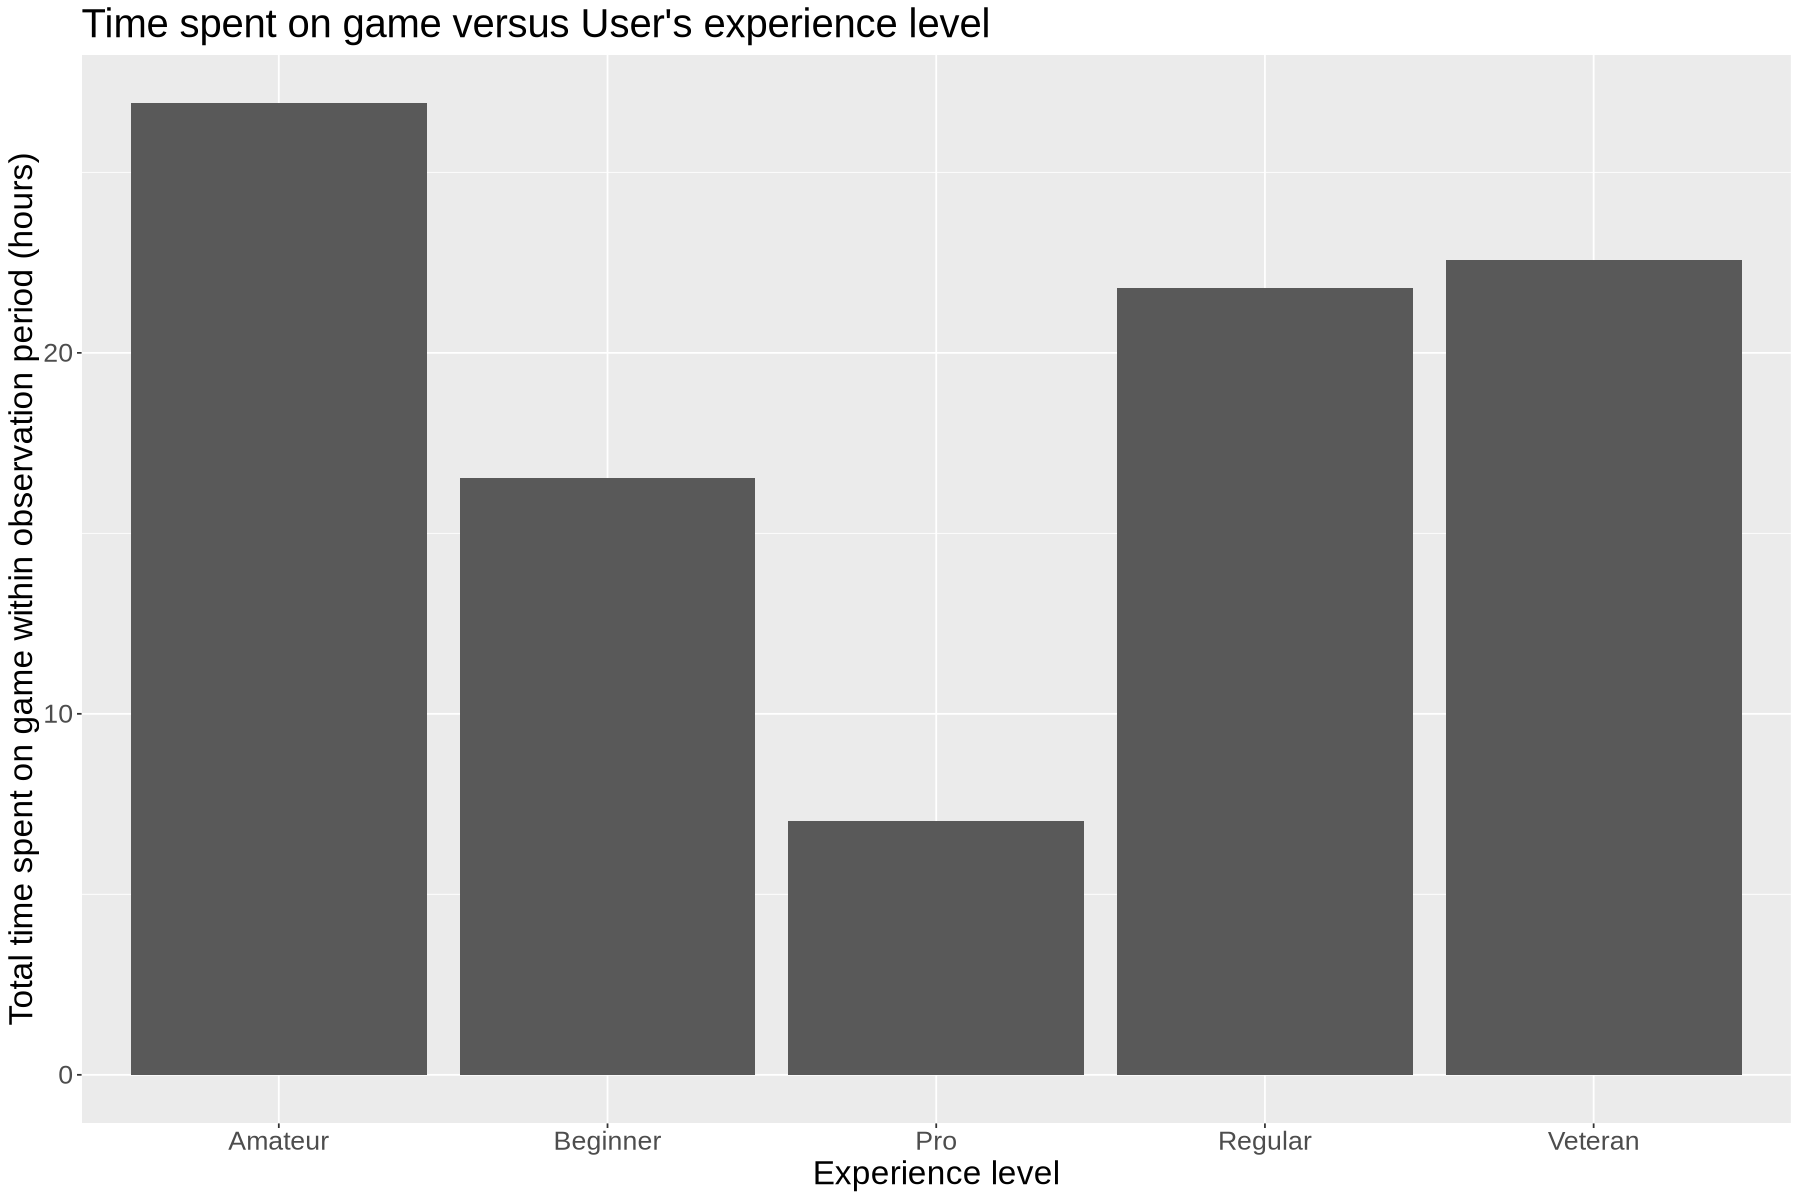

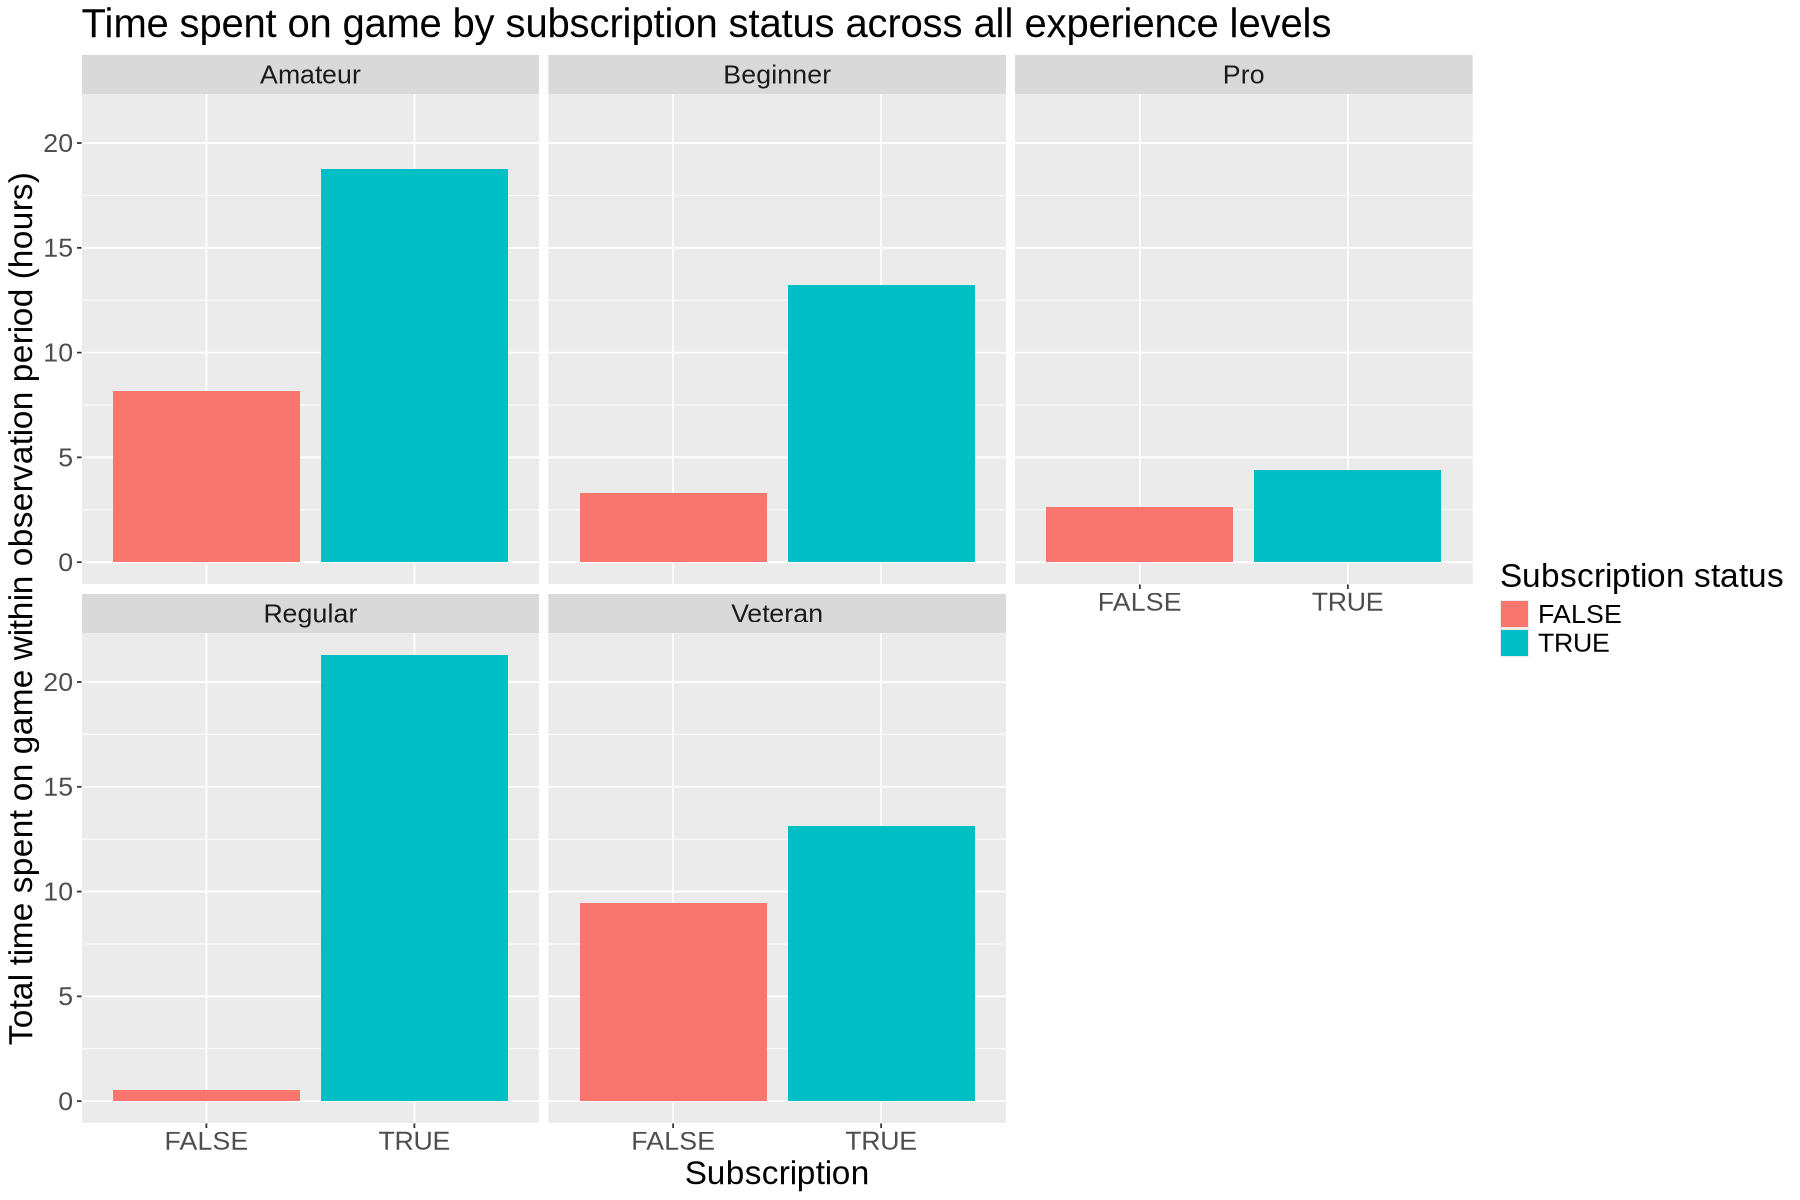

In [58]:
options(repr.plot.height = 10, repr.plot.width = 15)

cd_filtered <- combined_data|>
    filter(total_session_hrs <= 20)|>
    filter(total_session_mins <= 500)
cd_filtered #The outliers were making the graph a bit hard to read + all the outliers are subscribed

time_vs_sub_plot <- cd_filtered|>
    ggplot(aes(x = total_session_hrs, fill = subscribe))+
    geom_histogram()+
    labs(x = "Total time spent on game within observation period (hours)", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus Subscription status")
time_vs_sub_plot

class_vs_sub_plot <- combined_data |>
     ggplot(aes(x = experience, fill = subscribe))+
    geom_bar()+
    labs(x = "Experience level", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("User's experience level versus Subscription status")
class_vs_sub_plot

time_vs_class_plot <- cd_filtered |>
    ggplot(aes(x = experience, y = total_session_hrs))+
    geom_bar(stat="identity")+
    labs(x = "Experience level", y = "Total time spent on game within observation period (hours)")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus User's experience level")
time_vs_class_plot

allrelationships <- cd_filtered|>
    ggplot(aes(x = subscribe, y = total_session_hrs, fill = subscribe))+
    geom_bar(stat="identity")+
    facet_wrap(~experience)+
    labs(x = "Subscription", y = "Total time spent on game within observation period (hours)", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game by subscription status across all experience levels")
allrelationships

Time vs subscription status:
- The more hours one spends on the game, the more likely a player is to subscribe

Experience vs subscription status:
- Seems the subscription rate is higher than not regardless of experience

Experience vs time:
- Level is very likely self declared due to irregularity
  -  Usually more hours = higher experience level, but it's not the case for this dataset
- Players of higher status have very likely played the game outside of this observation
- Bias might hinder reliability and will result in targetting the wrong audience
  -  Unless they have a very specific metric of measurement for these experience levels

Time spent on game by subscription status across all experience levels:
- Regulars seem to have the highest subscription ratio
- Should target regulars and amateurs since they have the highest play time
- But we need to be specific with what "regulars" and "amateurs" mean because if left ambiguous we might target the wrong audience
- Looks like subscription would be an okay unit of measurement for time spent because it checks out how more time = bigger subscription chance
- The ratios are very different for all levels of experience, which might make it easier to pre

(4) Methods and Plan:
-

Linear regression
- Response variable is continuous
- Equation for the straight line directly describes the relationship between predictors and response variable
- Need to assume linearity and independence

Limitations
- Over generalising each category of player
  -  A regular might not have exactly N amount of hours played more than an amateur
  -  May affect how effectively the model can predict the target audience
- Missing values for end_time

Method
- 70-30 split at the start
- Cross validation to ensure good predictive performance and avoid validation set
- Can try with knn-regression
  -  Doesn't assume linearity, so more flexible for unexpected relationships
  -  Overall interpretability might be unsatisfactory because the answer to questions like "how many hours do x play more than y" would be "it depends"
      *    Not ideal if I need to find a target audience
-  Use rmse to compare their accuracies
-  But need to consider the practical use of each model based on the question regardless of accuracy